In [1]:
%matplotlib inline

In [2]:
import gym
import tensorflow as tf
import numpy as np
import math
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import random
import time

In [3]:
from experiencereplay import ExperienceReplay, PrioritizedExperienceReplay
from experiment import Experiment
from ddpg import DDPG
import nn
from exploration import EpsilonGreedyStrategy, OUStrategy
from ounoise import OUNoise

In [4]:
settings = dict(
    environment = 'Reacher-v1',
    timesteps = 10000,
    batch_size = 64,
    learning_start = 256,
    discount_factor = 0.9,

    max_replay_buffer_size = 100000,
    
    actor_learning_rate=0.0001,
    q_learning_rate=0.001,
    
    actor_l2=None,
    q_l2=None,
    
    actor_target_approach_rate=0.99,
    q_target_approach_rate=0.99,
    
    train_updates_per_step = 10,
    priority_updates_per_step = 100,
    
    actor_net_layers = [256, 128],
    actor_net_activation_fn = tf.nn.elu,
    actor_bounded_output = True,
    q_net_embedding = 128,
    q_net_layers =  [128],
    q_net_activation_fn = tf.nn.elu,
 
    environment_seed = 1,
    noise_seed= 0,
    
    gpu_memory_fraction = 0.1,
    
    render_start=9500,
    render_environment = True,
    render_frequency = 10,
)

settings["experiment_path"] = "experiments/experiment_ddpg_{}_{}".format(settings["environment"], int(time.time()))
settings["actor_tf_optimizer"] = tf_optimizer = tf.train.AdamOptimizer(settings["actor_learning_rate"])
settings["q_tf_optimizer"] = tf_optimizer = tf.train.AdamOptimizer(settings["q_learning_rate"])

In [5]:
def preprocess_state(observation):
    state = np.array(observation)
    if settings["environment"] == "MountainCarContinuous-v0":
        state[1] = state[1] * 10
        return state
    else:
        return state
    
def preprocess_reward(reward):
    if settings["environment"] == "MountainCarContinuous-v0":
        return reward * 0.01
    else:
        return reward

In [6]:
env = gym.make(settings["environment"])
env.seed(settings["environment_seed"])

observation = preprocess_state(env.reset())
state = observation

[2017-05-22 07:06:42,212] Making new env: Reacher-v1


In [7]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

print(state_dim)
print(action_dim)
print(env.observation_space.high)
print(env.observation_space.low)
print(env.action_space.high)
print(env.action_space.low)

11
2
[ inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
[ 1.  1.]
[-1. -1.]


In [8]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=settings["gpu_memory_fraction"])
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [9]:
actor_network = nn.fully_connected("Actor", session, [state_dim], settings["actor_net_layers"],
                                   action_dim, settings["actor_net_activation_fn"],
                                   env.action_space if settings["actor_bounded_output"] else None, True)
q_network = nn.fully_connected_with_input_embedding("Q", session, [state_dim, action_dim],
                               settings["q_net_embedding"], settings["q_net_layers"], 1,
                               settings["q_net_activation_fn"], None, True)

print(str(actor_network))
print(str(q_network))

[] --> Actor_input_0
['Actor_input_0'] --> bn_hidden_0
['bn_hidden_0'] --> hidden_0_256
['hidden_0_256'] --> bn_hidden_1
['bn_hidden_1'] --> hidden_1_128
['hidden_1_128'] --> bn_output
['bn_output'] --> output
['output'] --> bounding

[] --> Q_input_0
['Q_input_0'] --> bn_encoding_0
['bn_encoding_0'] --> encoding_0_128
[] --> Q_input_1
['Q_input_1'] --> bn_encoding_1
['bn_encoding_1'] --> encoding_1_128
['encoding_0_128', 'encoding_1_128'] --> concat_inputs
['concat_inputs'] --> bn_hidden_0
['bn_hidden_0'] --> hidden_0_128
['hidden_0_128'] --> bn_output
['bn_output'] --> output



In [10]:
agent = DDPG(actor_network, q_network,
             discount_factor=settings["discount_factor"],
             actor_tf_optimizer=settings["actor_tf_optimizer"],
             q_tf_optimizer=settings["q_tf_optimizer"],
             actor_l2=settings["actor_l2"],
             q_l2=settings["q_l2"],
             actor_target_approach_rate=settings["actor_target_approach_rate"],
             q_target_approach_rate=settings["q_target_approach_rate"]
            )

In [11]:
experience_replay = PrioritizedExperienceReplay(agent, env, settings["max_replay_buffer_size"], False)

In [12]:
exploration_strategy = EpsilonGreedyStrategy(agent, env, settings["noise_seed"])

In [13]:
exp = Experiment(settings["experiment_path"], session, env, settings, settings["render_environment"], settings["render_frequency"], settings["render_start"])

progress_bar = tqdm(total=settings["timesteps"])
e_t = 0

for t in xrange(settings["timesteps"]):
    e_t += 1
    exploration = ((settings["timesteps"] - t) / float(settings["timesteps"])) ** 4
    if t < settings["learning_start"]:
        exploration = 1
    
    action = exploration_strategy.action(state, exploration)
    
    observation, reward, done, info = env.step(action)
    next_state = np.reshape(preprocess_state(observation), (state_dim,))
    
    experience_replay.add_experience(state, action, preprocess_reward(reward), next_state, done)
    td_error = math.fabs(experience_replay.get_last_td_error())
    exp.record(t, state, action, reward, next_state, done, td_error)
    
    state = next_state
    
    if t == 5000:
        experience_replay = PrioritizedExperienceReplay(agent, env, settings["max_replay_buffer_size"], False)
        settings["learning_start"] = 5100
        env.seed(0)
        done = True
    
    
    if done:
        observation = env.reset()
        state = preprocess_state(observation)
        e_t = 0
        
    if t >= settings["learning_start"]:
        experience_replay.train_agent(settings["batch_size"], settings["train_updates_per_step"])
        experience_replay.update_oldest_priorities(settings["priority_updates_per_step"])
            
    progress_bar.set_description('[{}][{}] reward: {:.2f}, reward 100MA: {:.2f}, Exploration: {:.2f}, action: {}, td-error: {:.4f}, ep_reward: {}, ep_dur: {}' \
        .format(t, e_t, reward, exp.reward_100ma.get_average(), exploration, str(action), td_error, exp.last_episode_reward, exp.last_episode_duration))
    progress_bar.update()
    
        
progress_bar.close()

[9509][4509] reward: -0.19, reward 100MA: -0.19, Exploration: 0.00, action: [-0.01197754 -0.02554649], td-error: 0.0035, ep_reward: 0, ep_dur: 0:  95%|█████████▌| 9510/10000 [21:03<01:08,  7.15it/s]          0:00<1:10:34,  2.36it/s][2017-05-22 07:27:49,228] GLFW error: 65544, desc: X11: RandR gamma ramp support seems broken
[9999][4999] reward: -0.16, reward 100MA: -0.16, Exploration: 0.00, action: [-0.00806937 -0.00871199], td-error: 0.0006, ep_reward: 0, ep_dur: 0: 100%|██████████| 10000/10000 [22:13<00:00,  7.15it/s]         


In [14]:
exp.save()
print("Experiment results saved in " + exp.path)

Experiment results saved in experiments/experiment_ddpg_Reacher-v1_1495429602


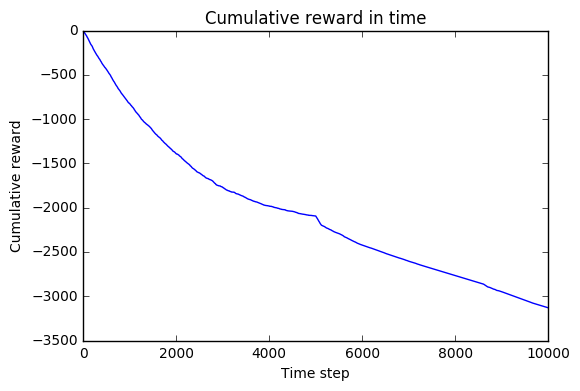

In [15]:
exp.plot_cumulative_reward()

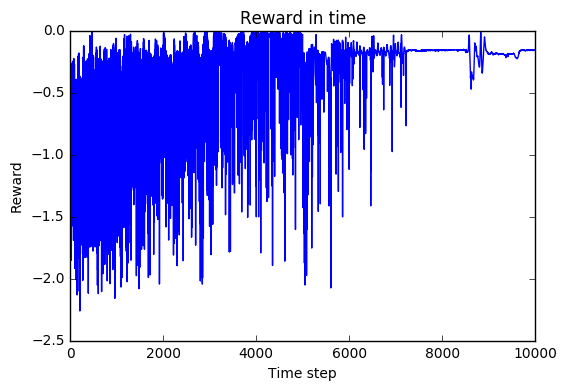

In [16]:
exp.plot_reward()

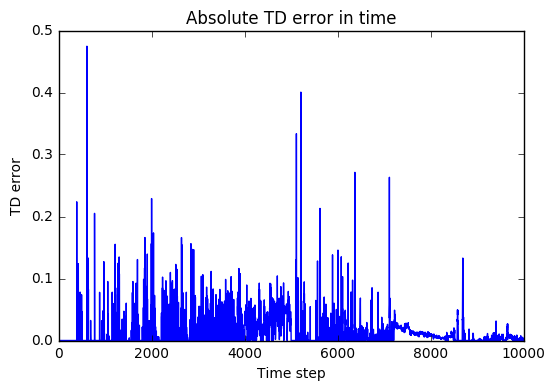

In [17]:
exp.plot_td_error()

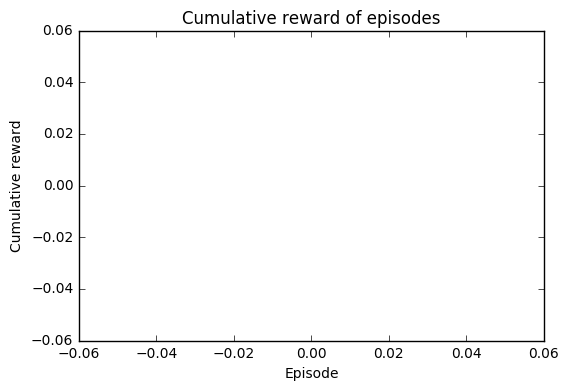

In [18]:
exp.plot_episode_reward()

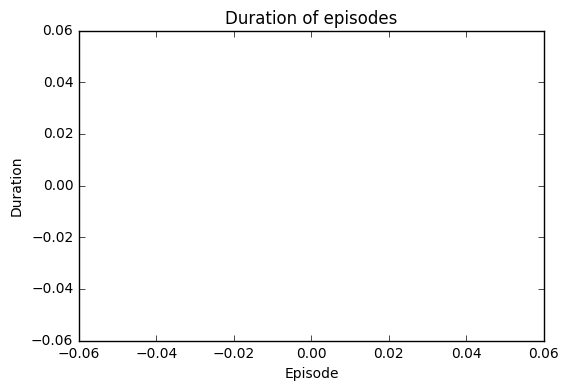

In [19]:
exp.plot_episode_duration()


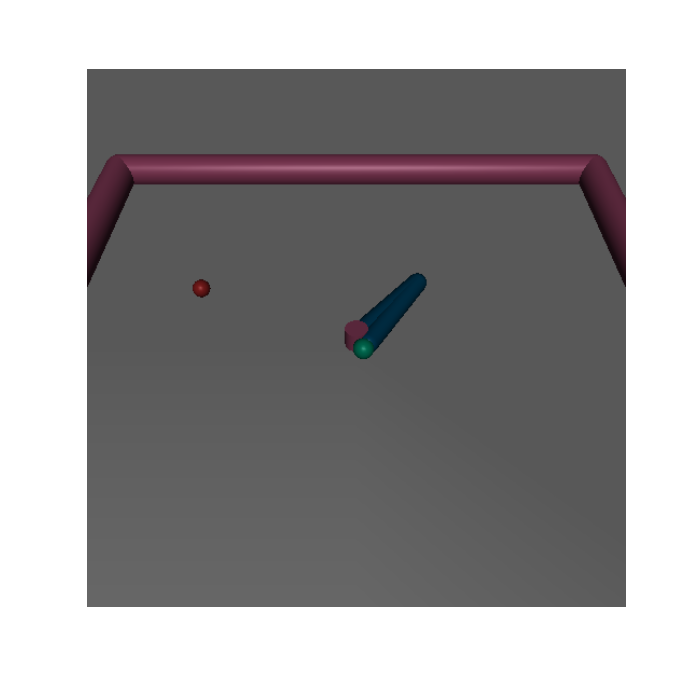
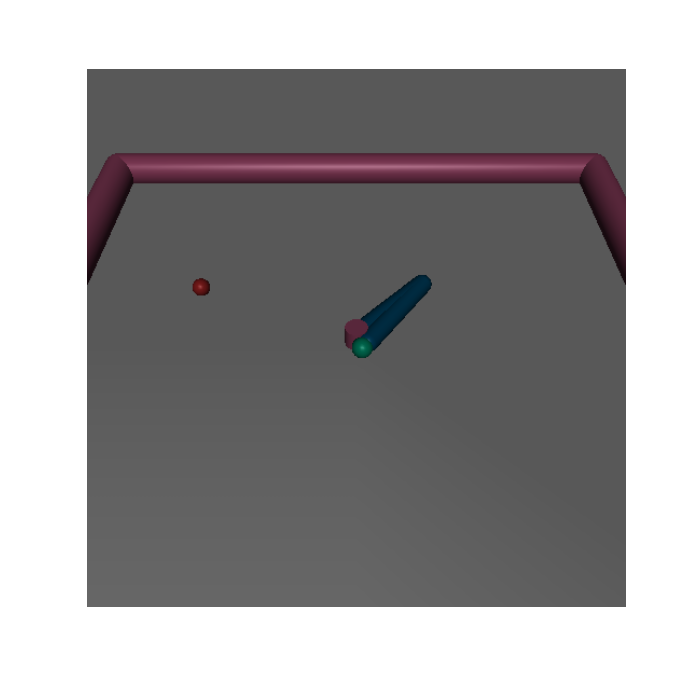
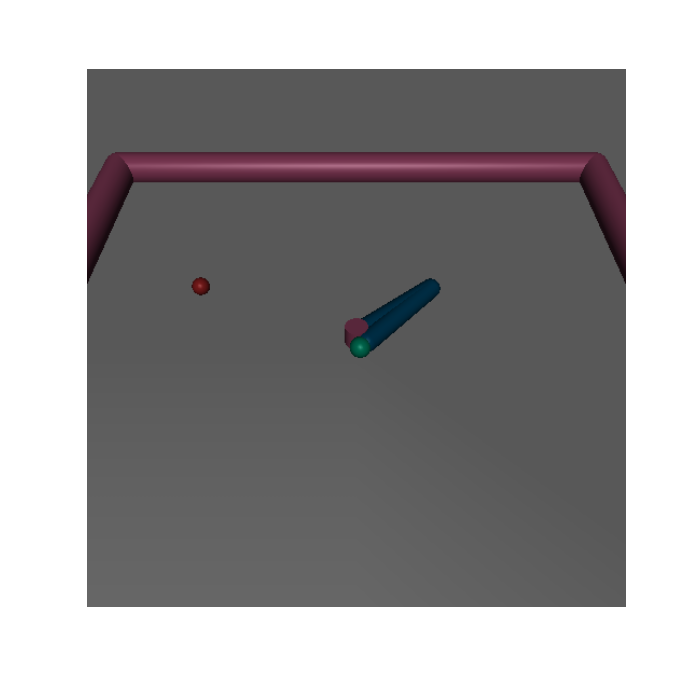
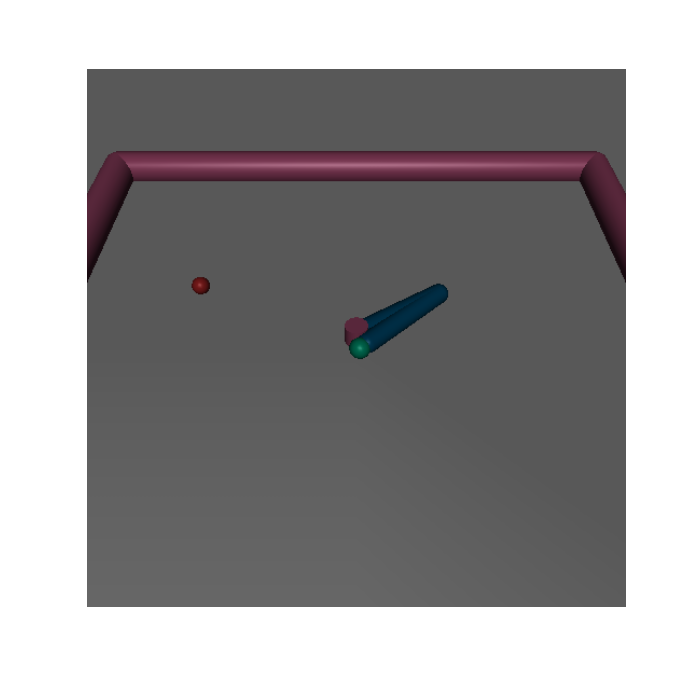
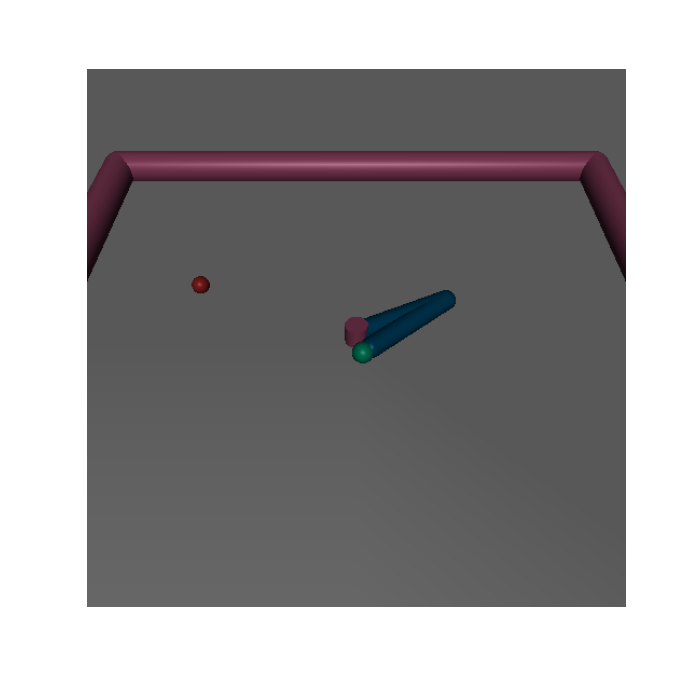
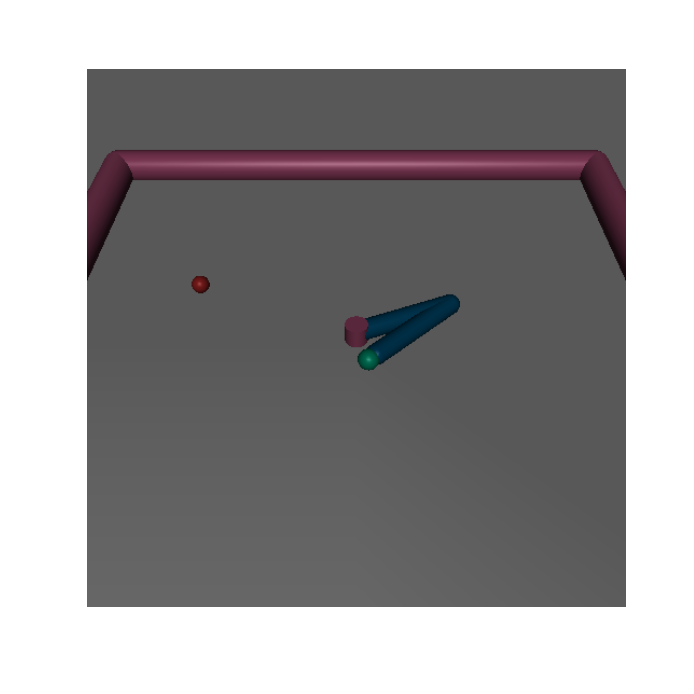
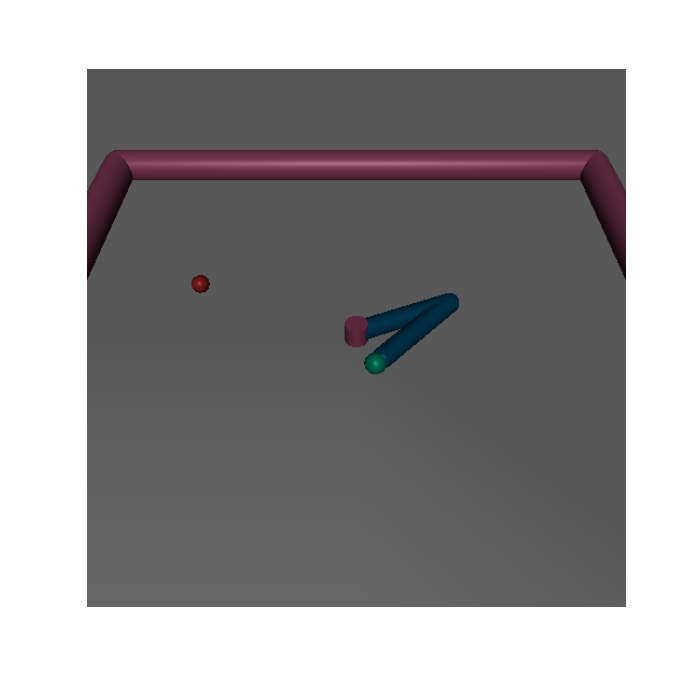
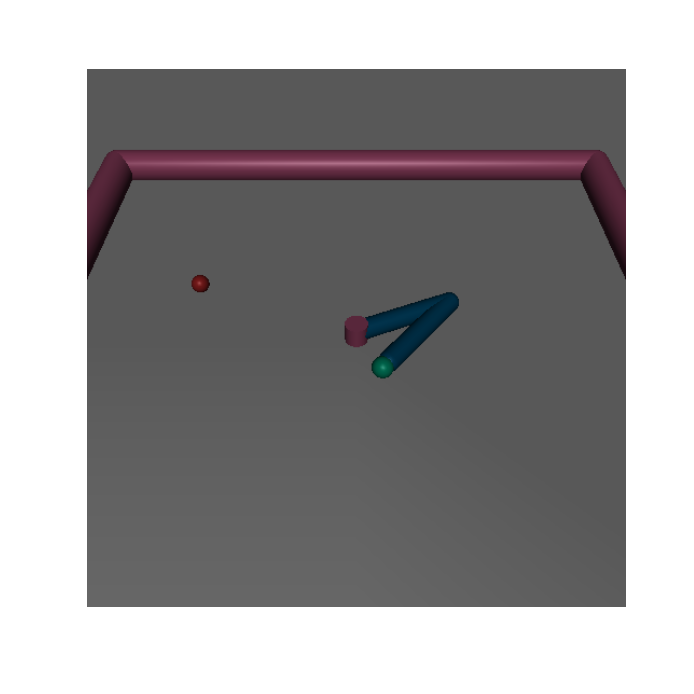
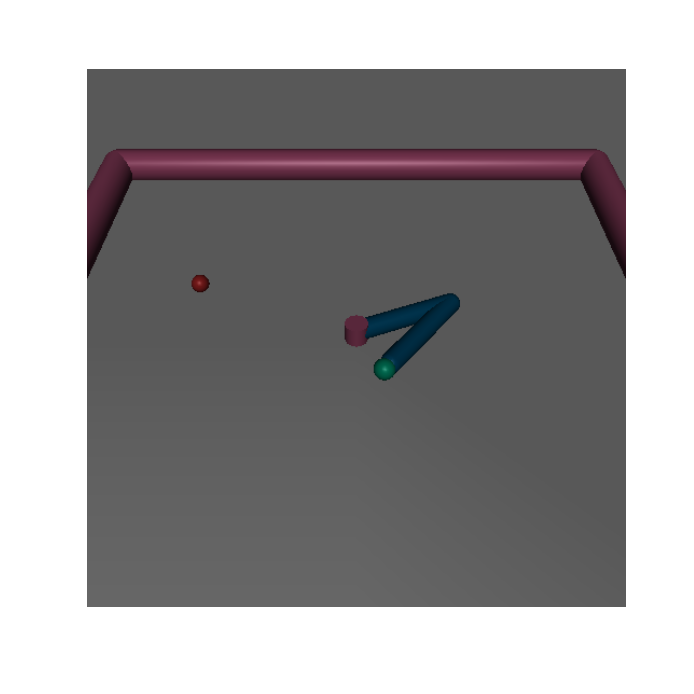
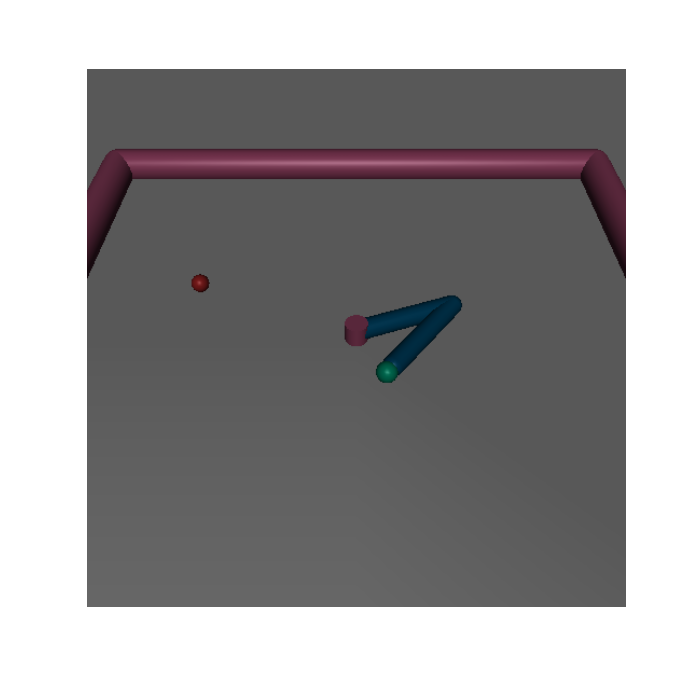
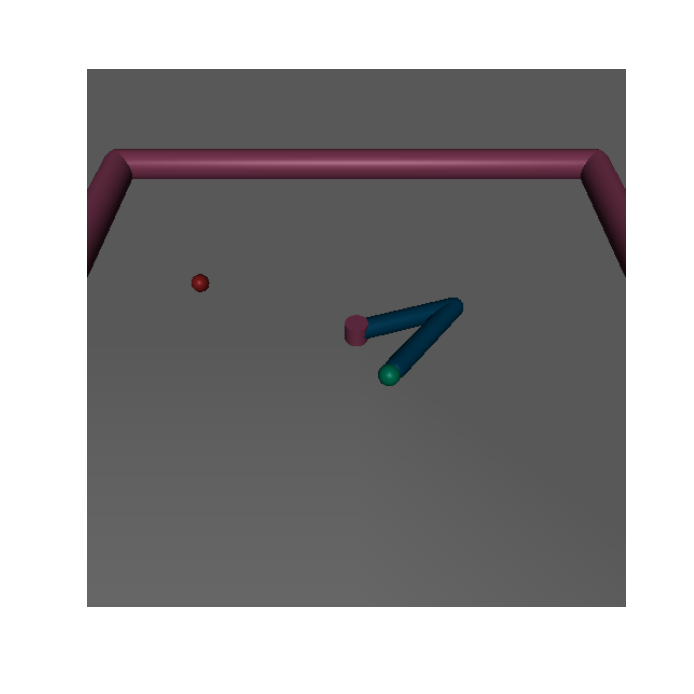
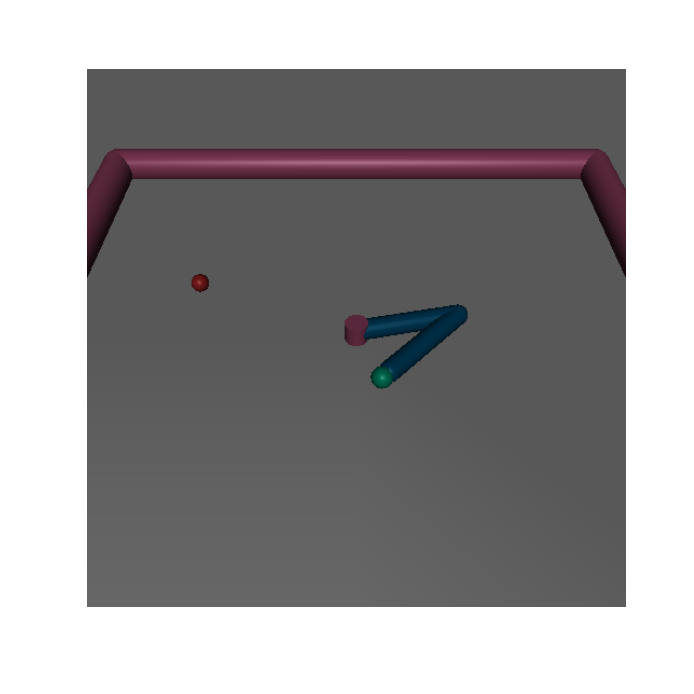
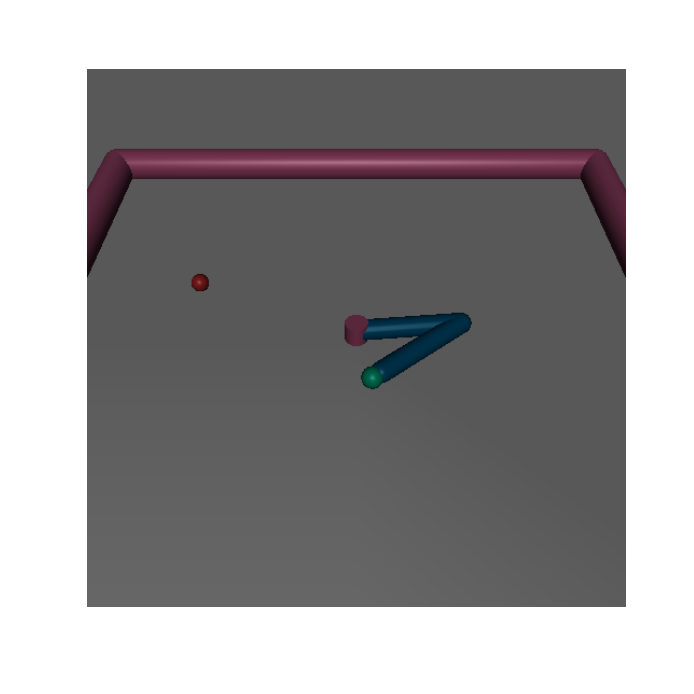
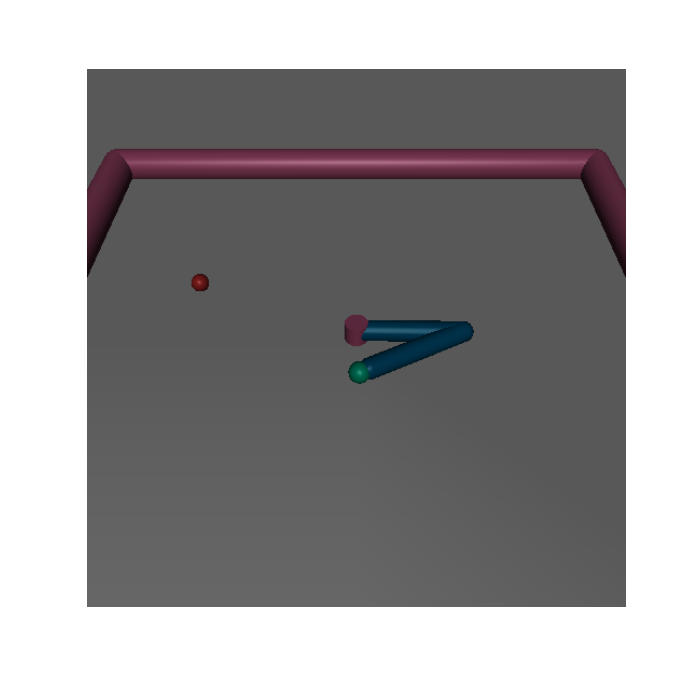
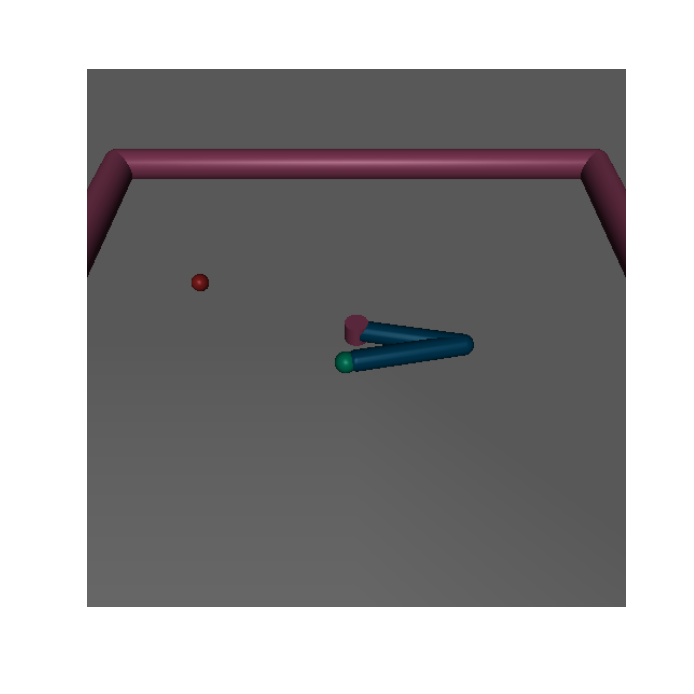
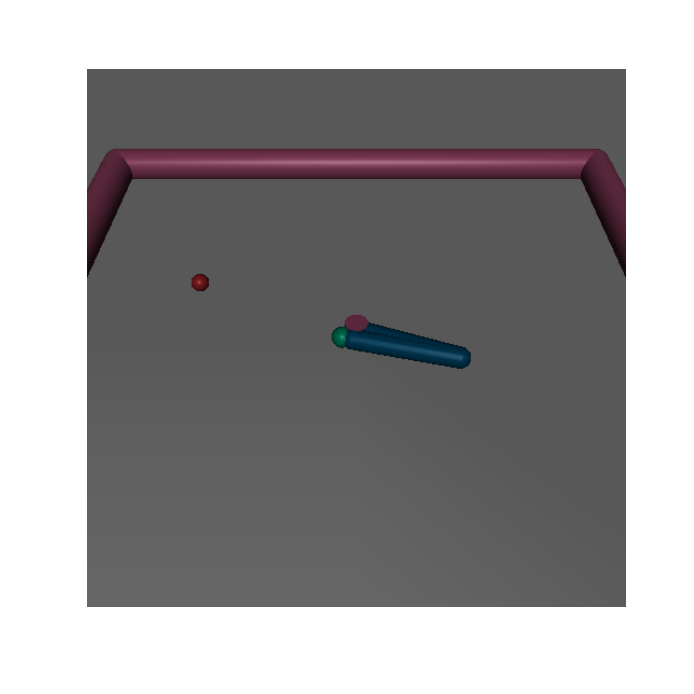
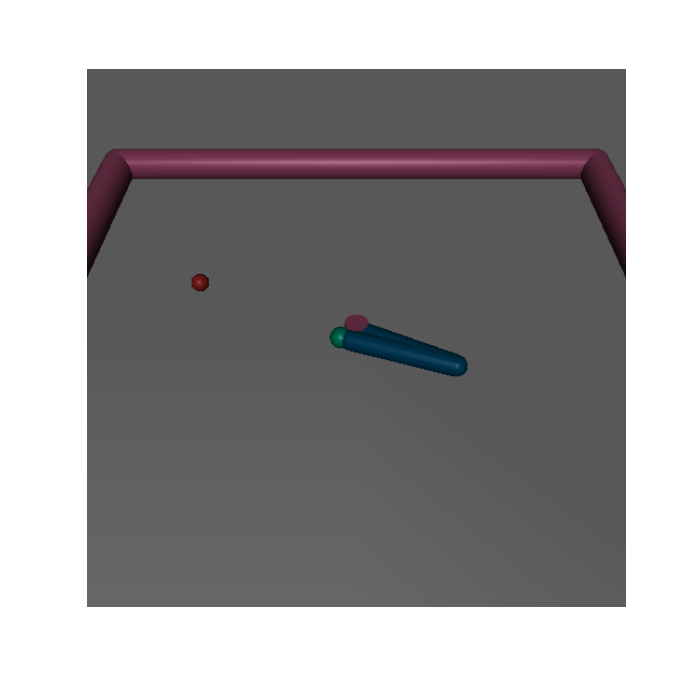
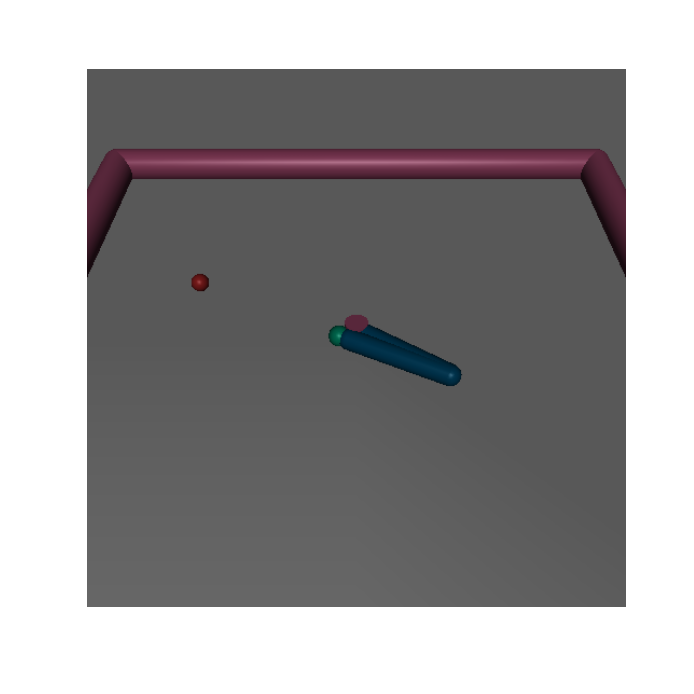
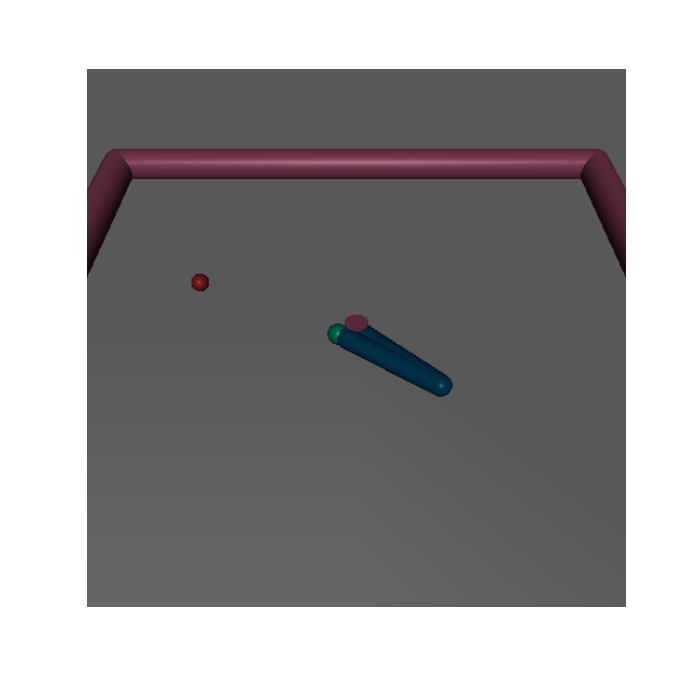
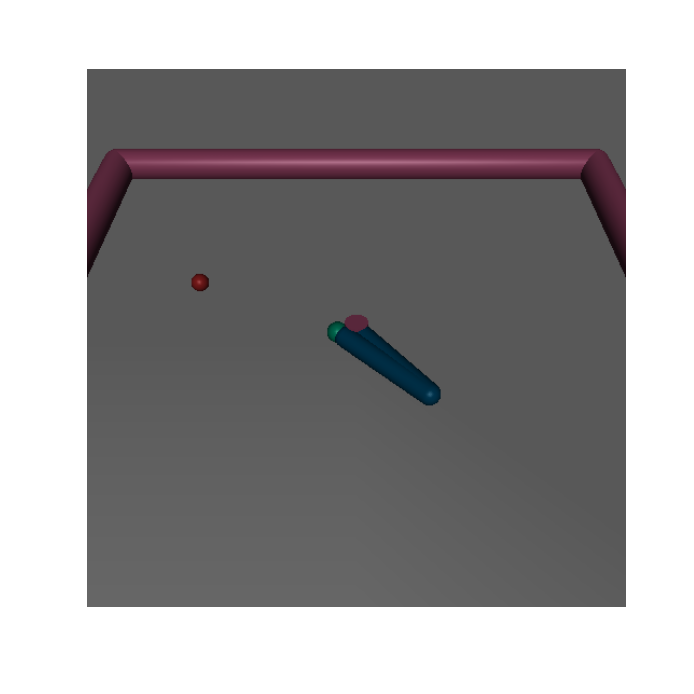
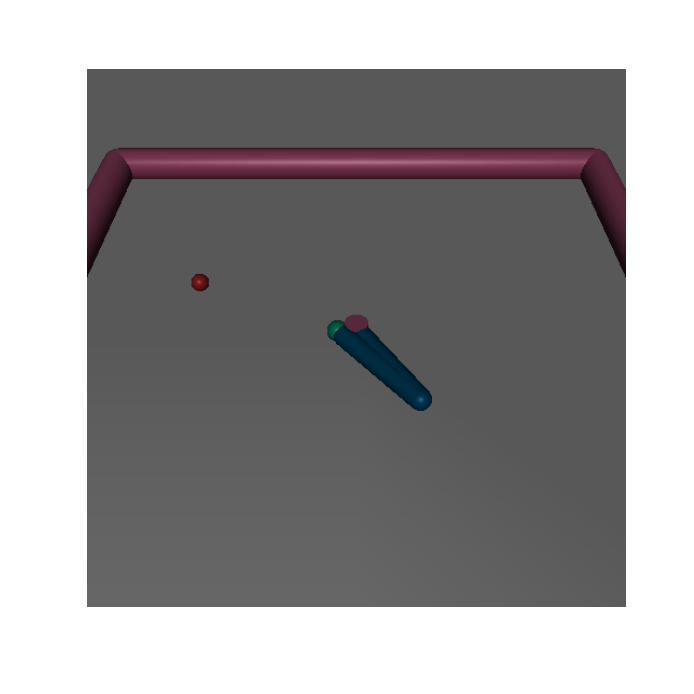
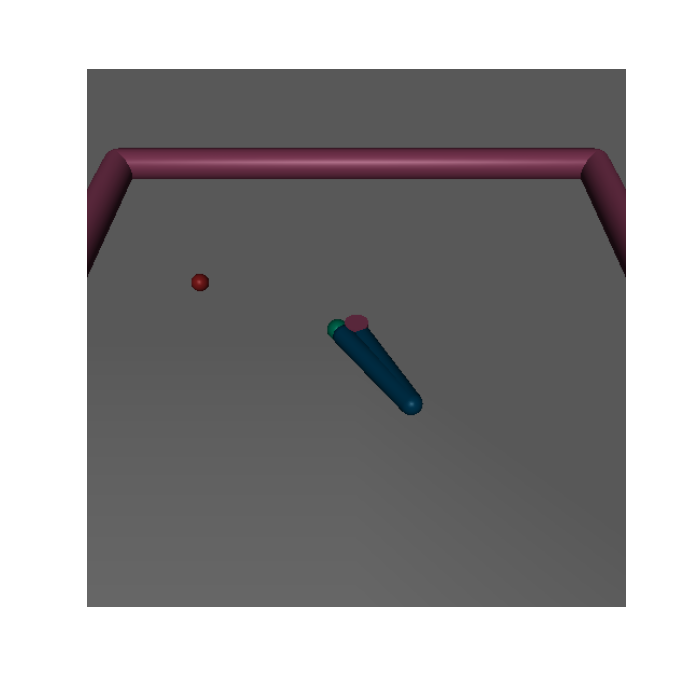
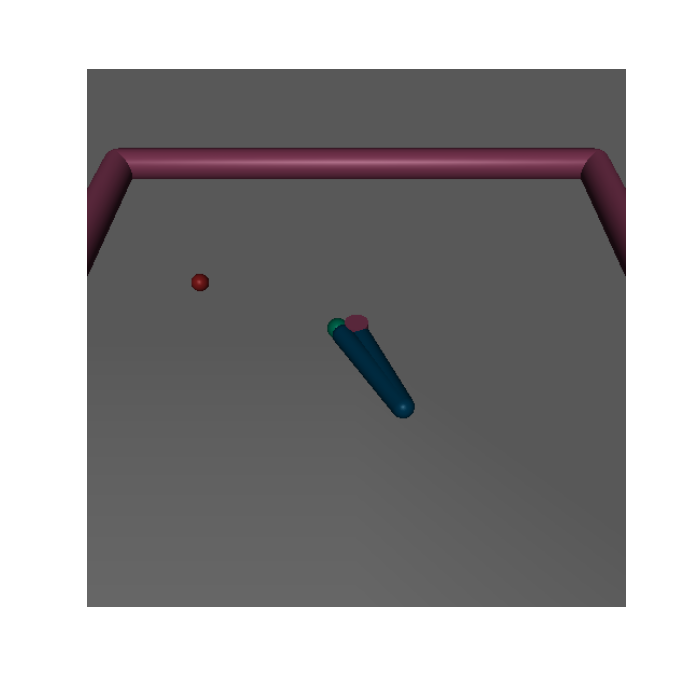
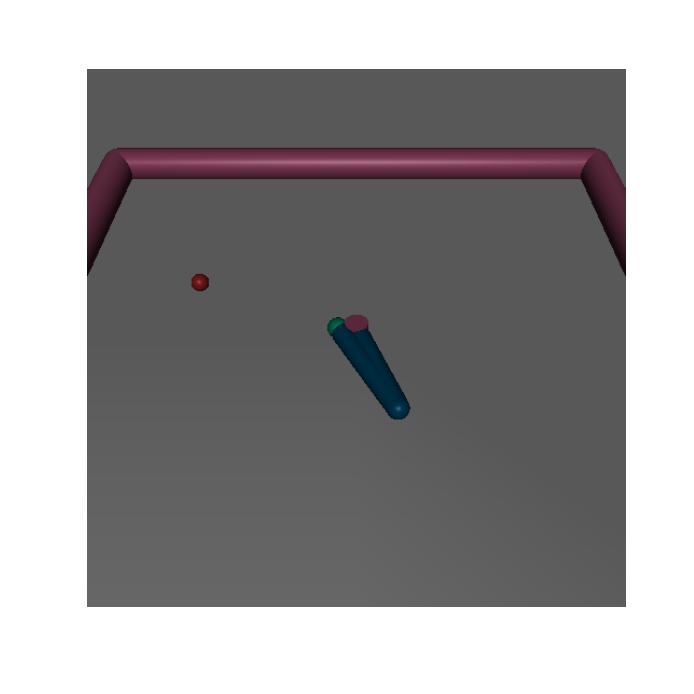
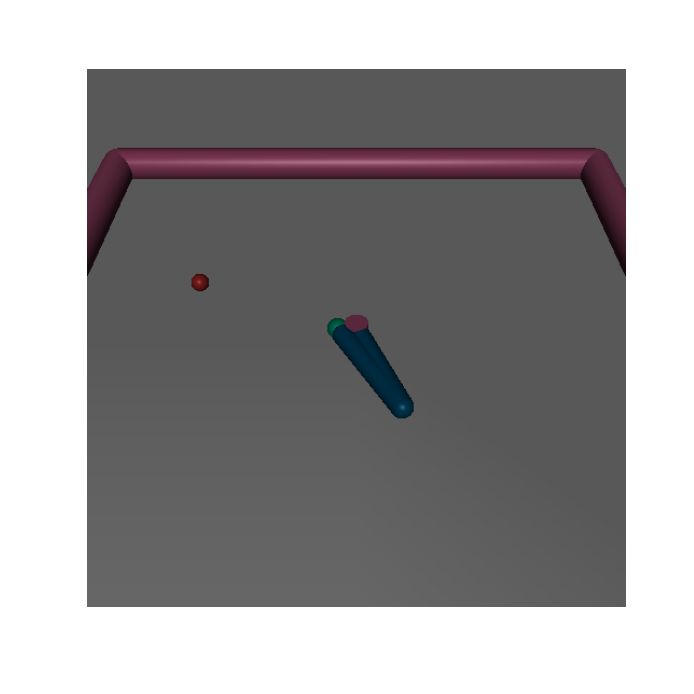
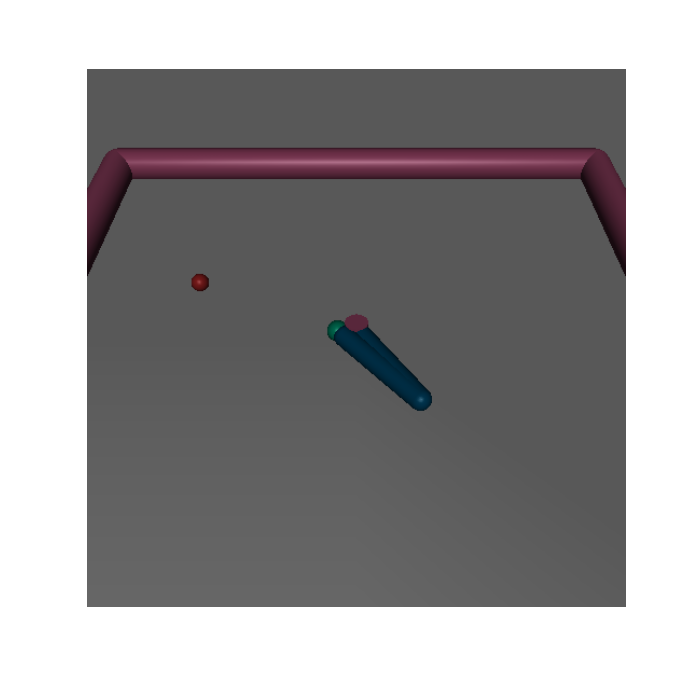
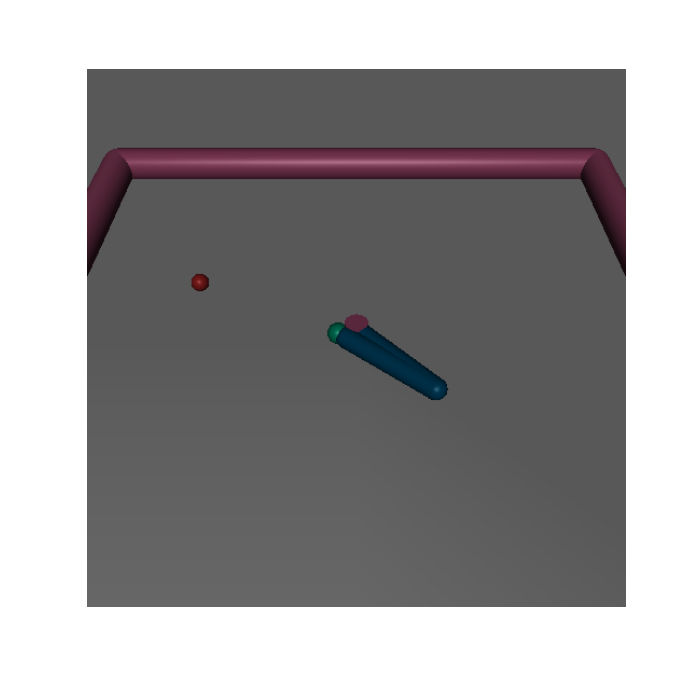
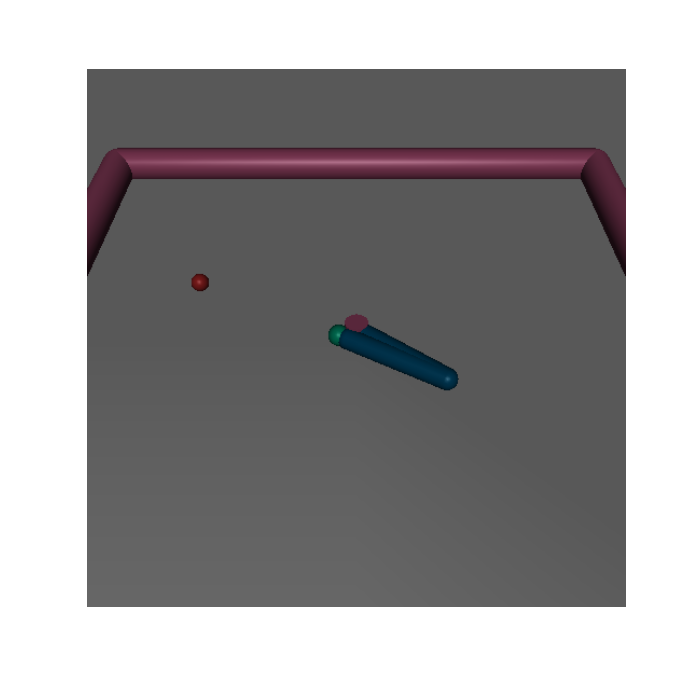
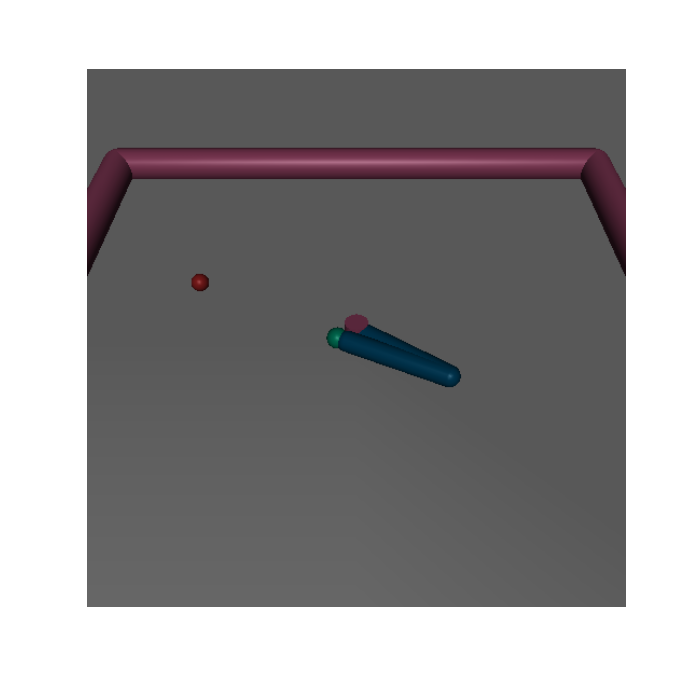
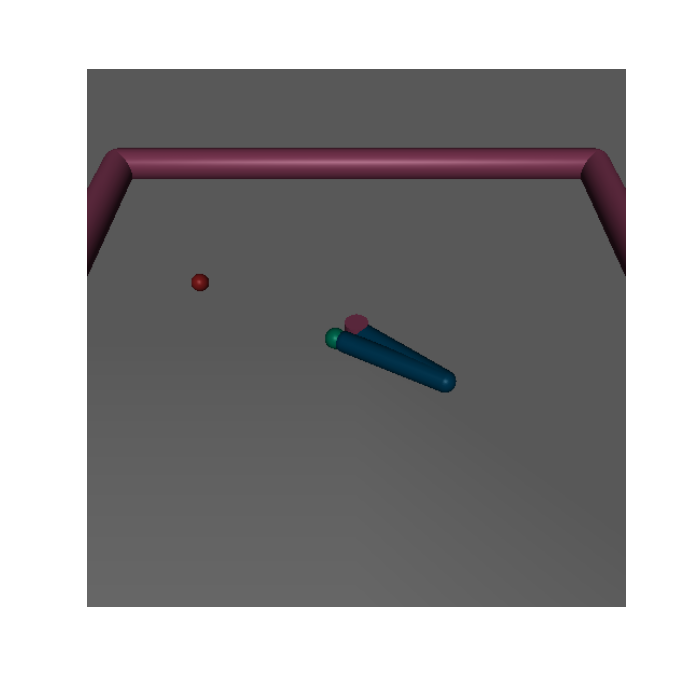
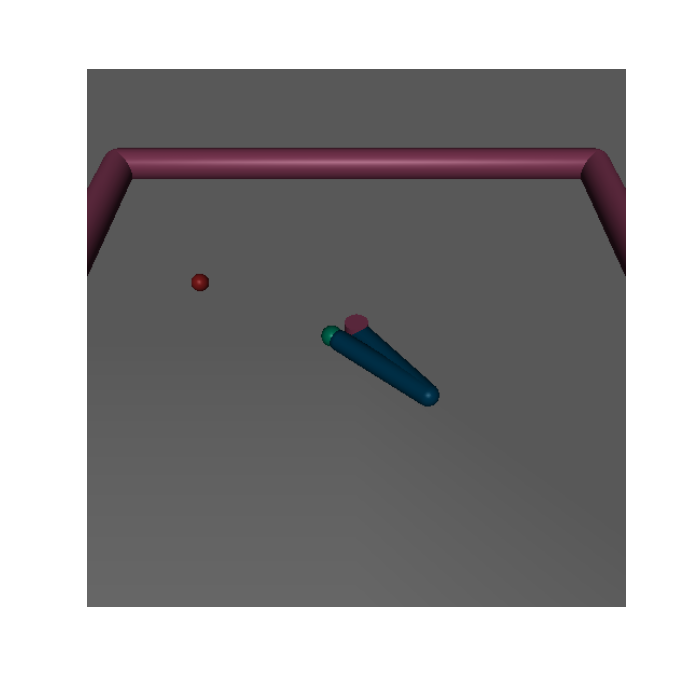
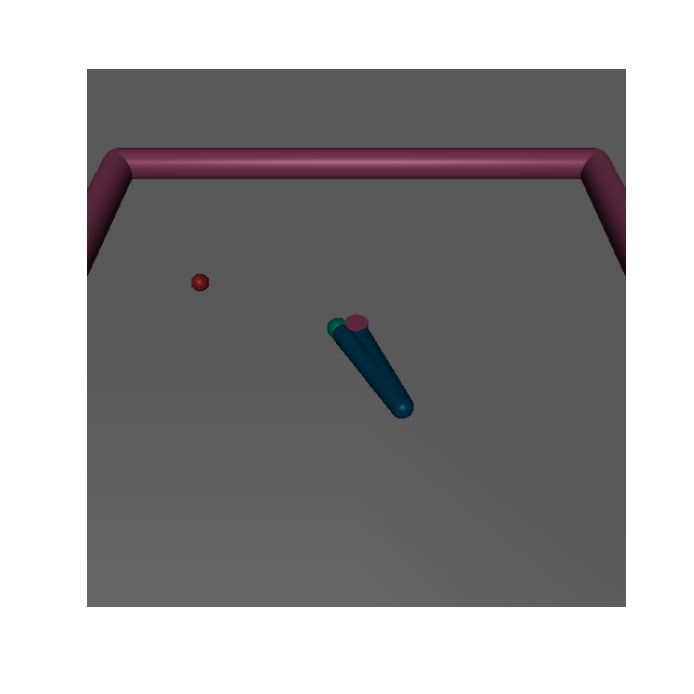
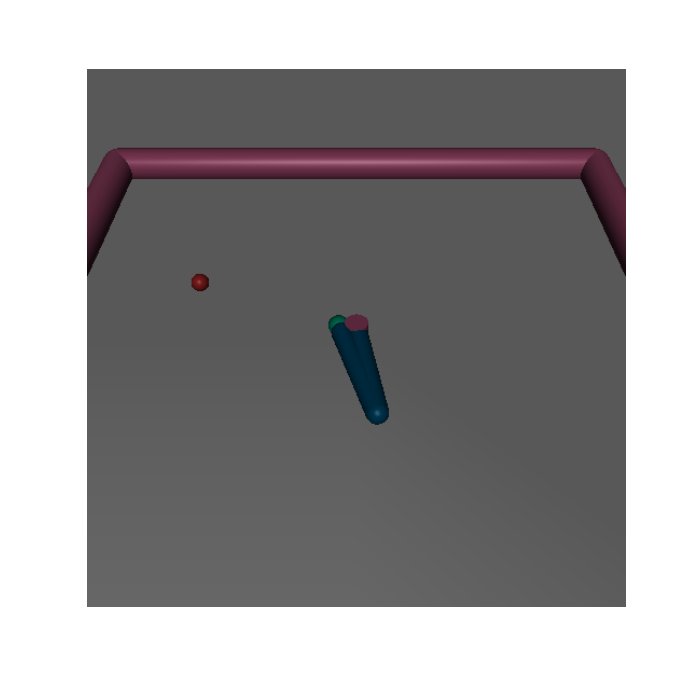
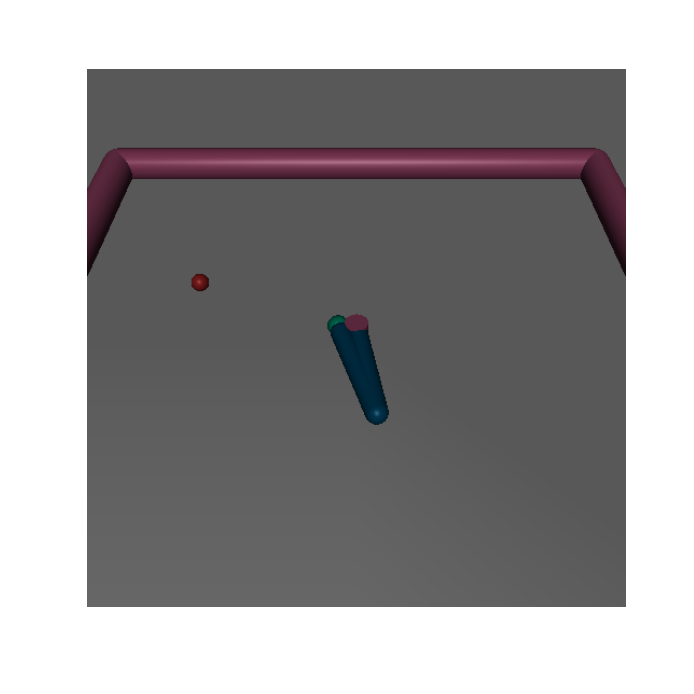
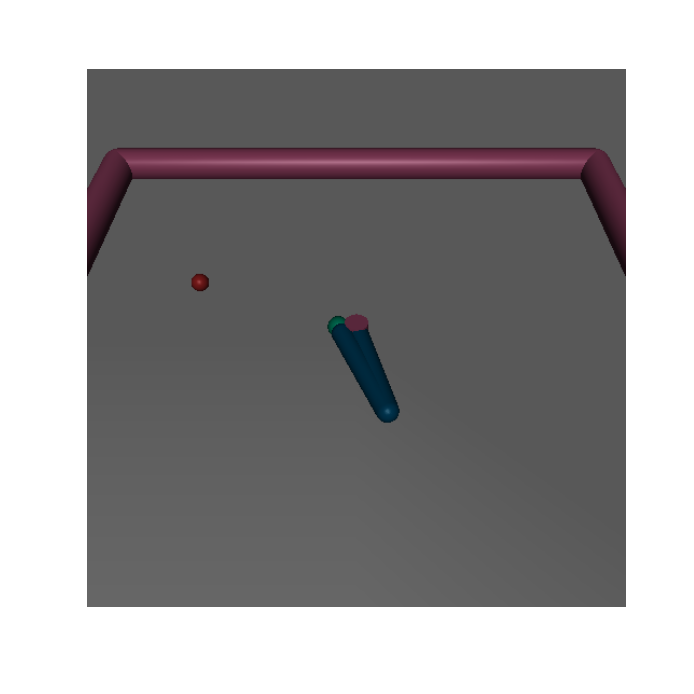
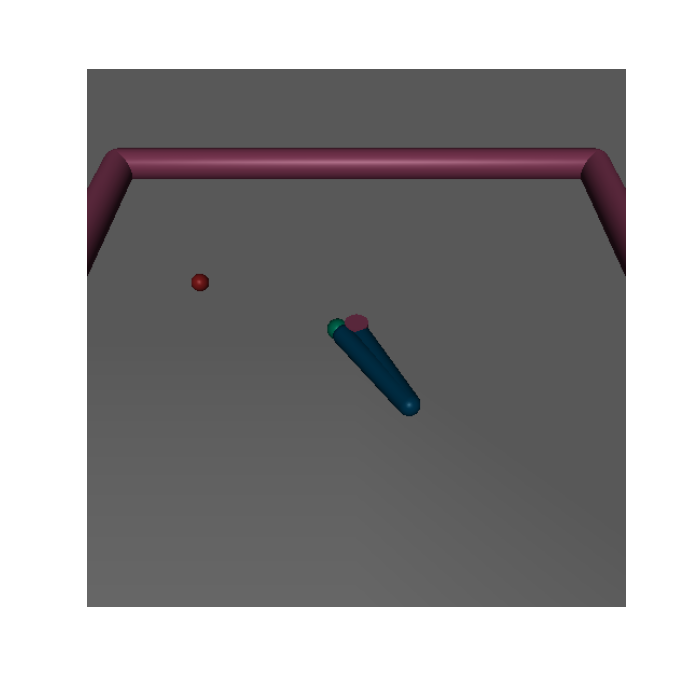
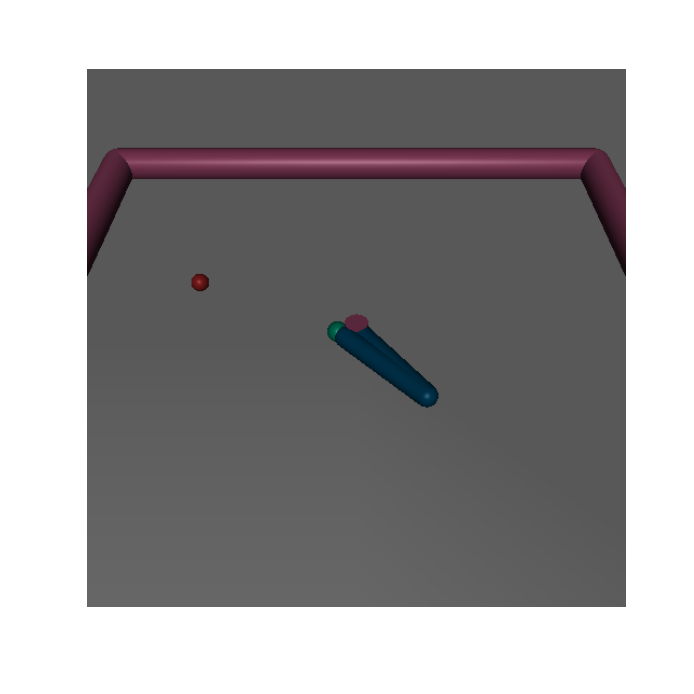
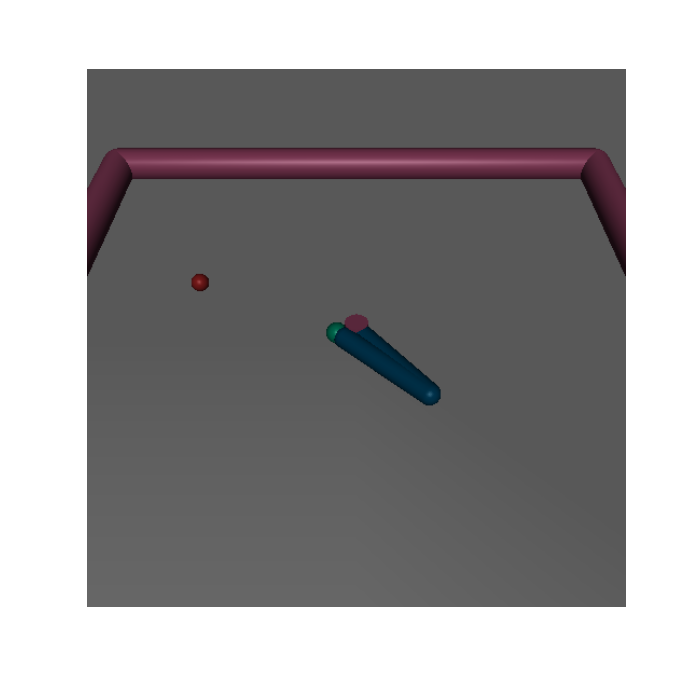
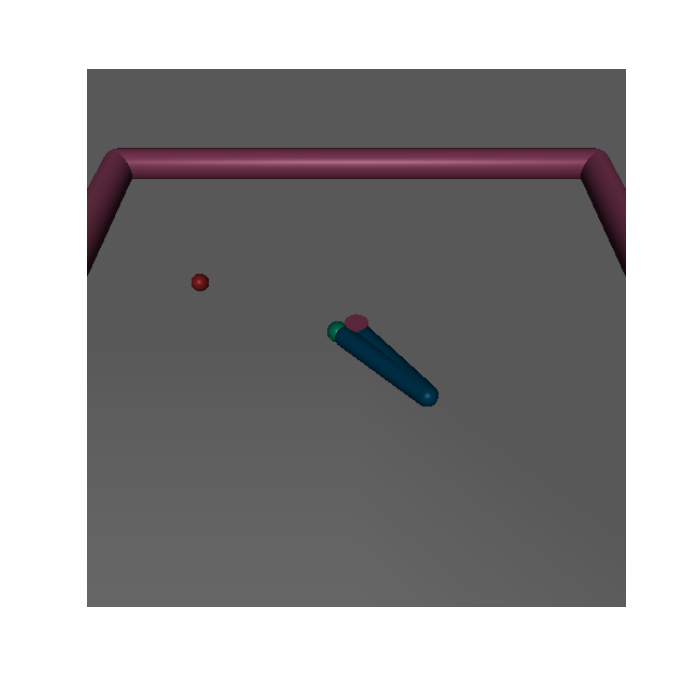
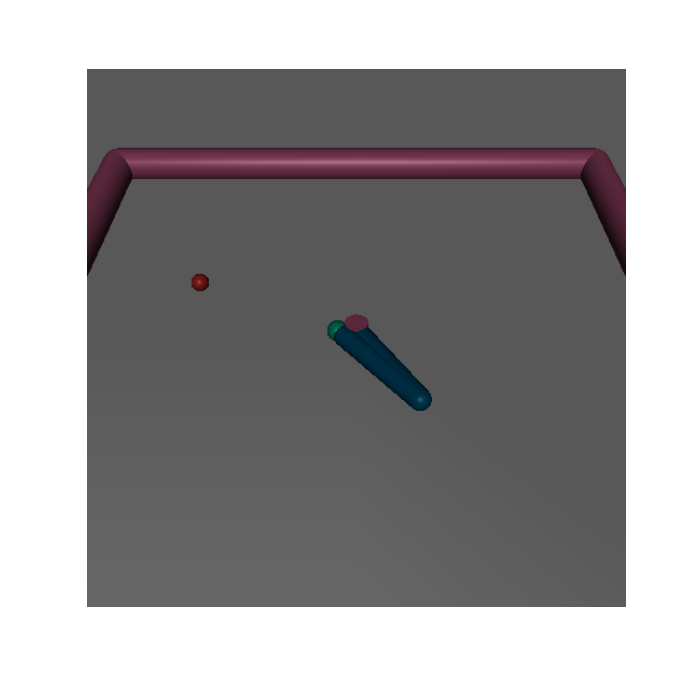
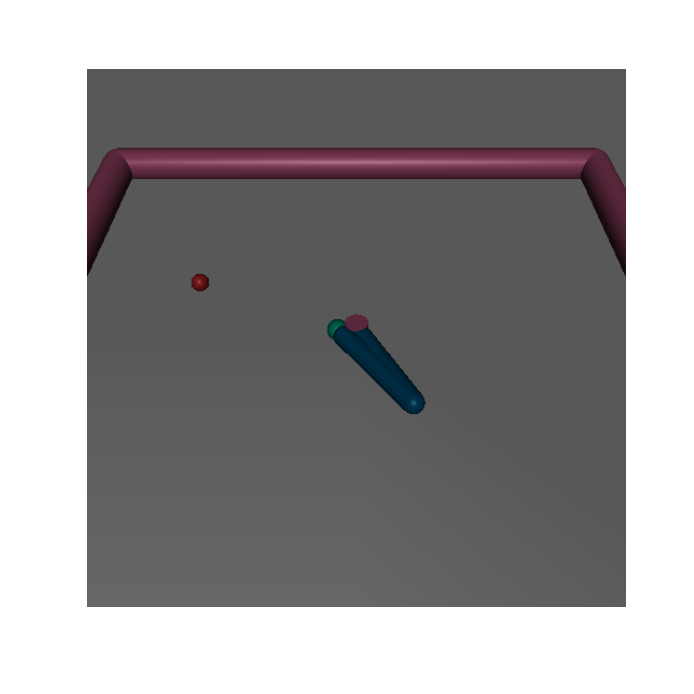
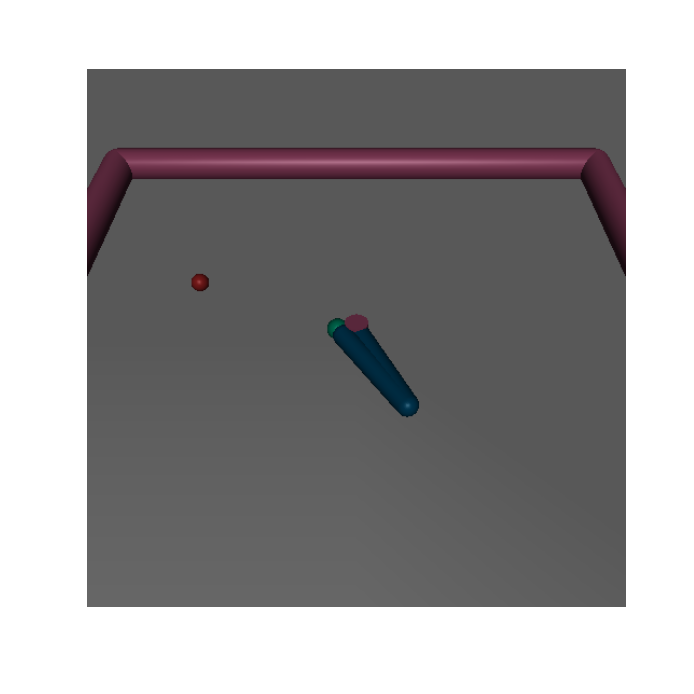
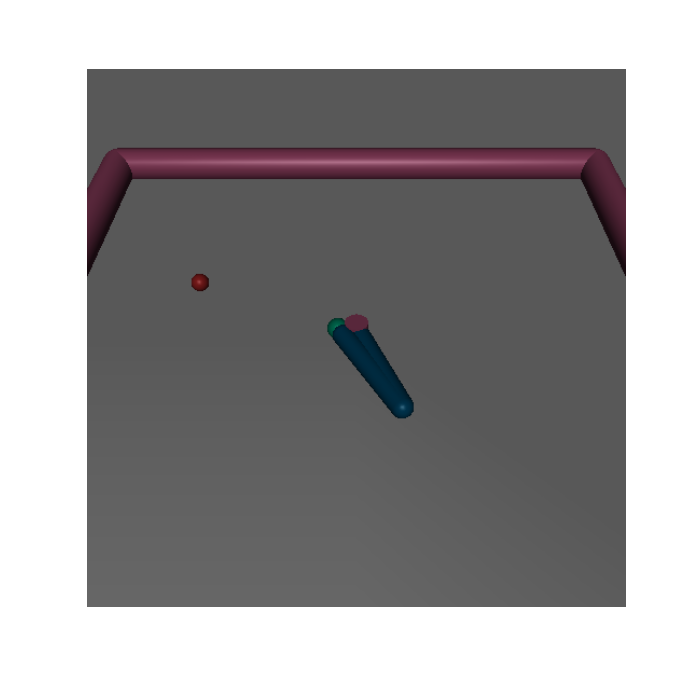
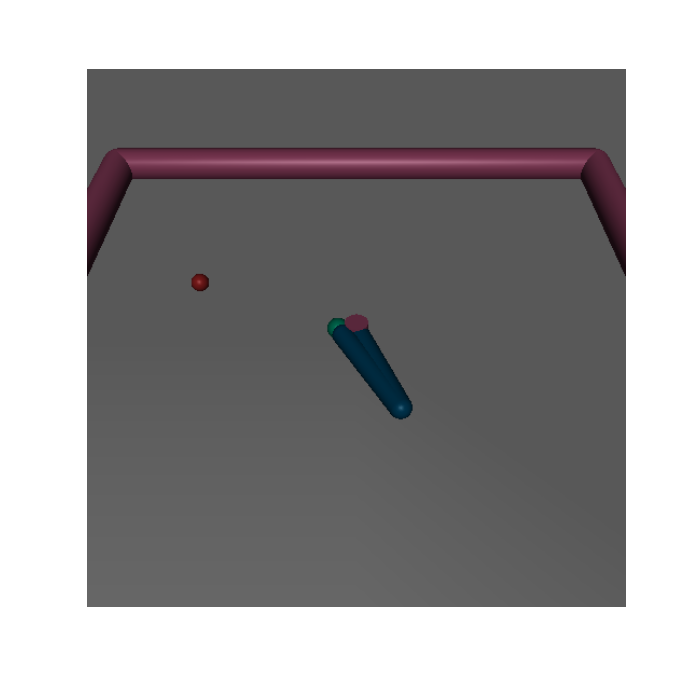
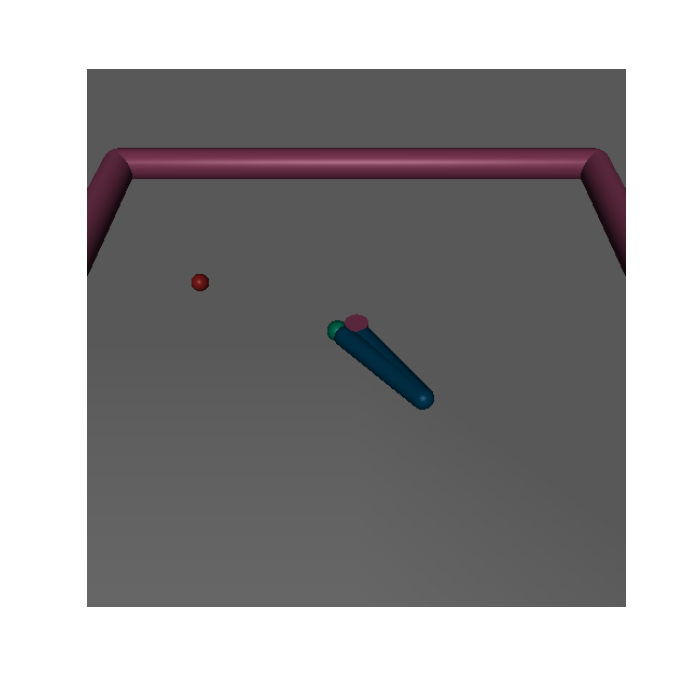
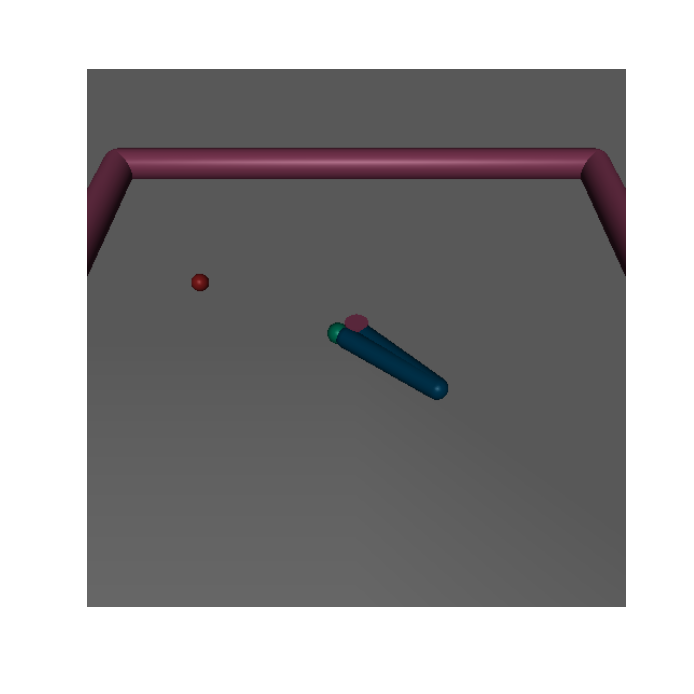
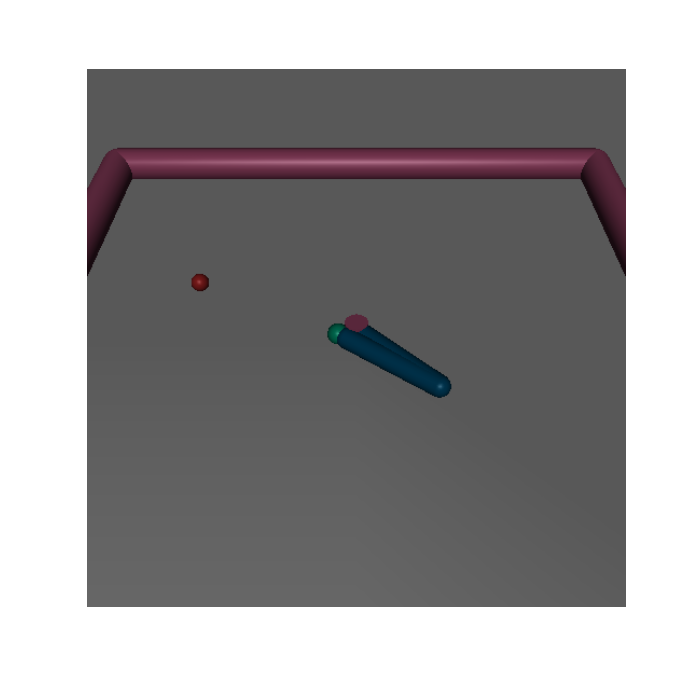
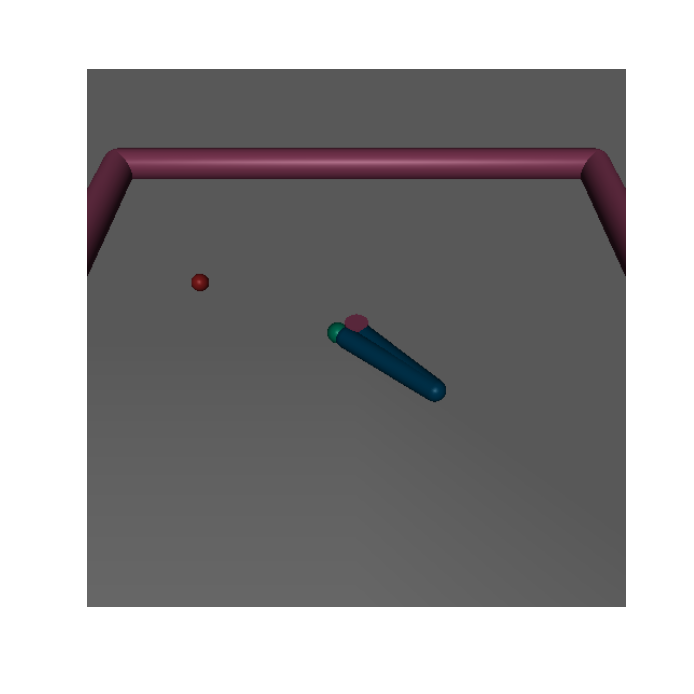
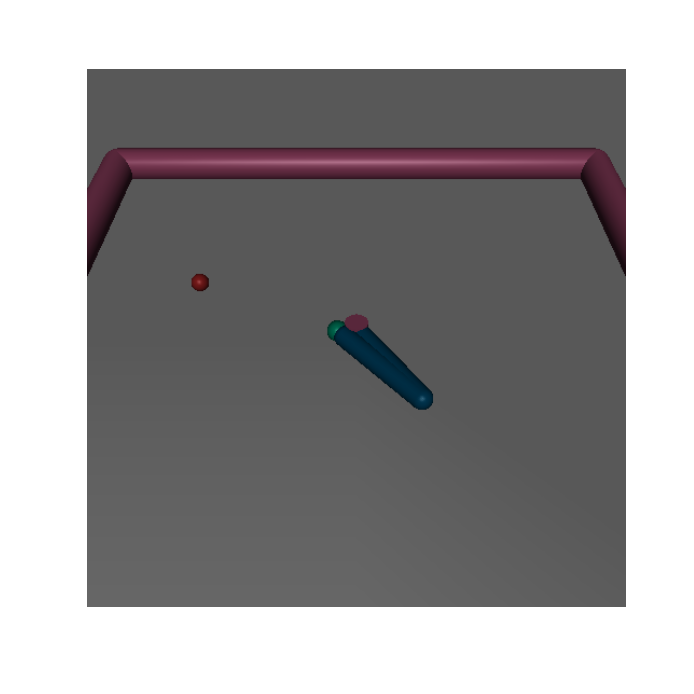

In [20]:
if settings["render_environment"]:
    exp.display_frames_as_gif()

In [21]:
#session.close()